# Dirac Notation Implementation - DEMO

2024-02-22

## Set up the environment

In [1]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr
session = WolframLanguageSession()

In [2]:
from diracdec import *
from diracdec import dirac_delta_parse as parse, dirac_delta_trs as trs

In [3]:
sub = Subst({
    "ket0" : parse('''KET('0')'''),
    "bra0" : parse('''BRA('0')'''),
    "ket1" : parse('''KET('1')'''),
    "bra1" : parse('''BRA('1')'''),
    "ketP" : parse(''' "Sqrt[1/2]" SCRK (ket0 ADDK ket1) '''),
    "braP" : parse(''' "Sqrt[1/2]" SCRB (bra0 ADDB bra1) '''),
    "ketM" : parse(''' "Sqrt[1/2]" SCRK (ket0 ADDK ("-1" MLTK ket1)) '''),
    "braM" : parse(''' "Sqrt[1/2]" SCRB (bra0 ADDB ("-1" MLTB bra1)) '''),

    "beta00" : parse(''' "Sqrt[1/2]" SCRK ((ket0 TSRK ket0) ADDK (ket1 TSRK ket1))'''),

    "I2" : parse('''(ket0 OUTER bra0) ADDO (ket1 OUTER bra1)'''),

    "Z" : parse('''(ket0 OUTER bra0) ADDO ("-1" SCRO (ket1 OUTER bra1))'''),

    "X" : parse('''(ket0 OUTER bra1) ADDO (ket1 OUTER bra0)'''),

    "Y" : parse('''("-I" SCRO (ket0 OUTER bra1)) ADDO ("I" SCRO (ket1 OUTER bra0))'''),


    "H" : parse(''' "Sqrt[1/2]" SCRO ((ket0 OUTER bra0) ADDO (ket0 OUTER bra1) ADDO (ket1 OUTER bra0) ADDO ("-1" SCRO (ket1 OUTER bra1)))'''),

    "CX": parse(''' ((ket0 TSRK ket0) OUTER (bra0 TSRB bra0))
                ADDO ((ket0 TSRK ket1) OUTER (bra0 TSRB bra1)) 
                ADDO ((ket1 TSRK ket1) OUTER (bra1 TSRB bra0))
                ADDO ((ket1 TSRK ket0) OUTER (bra1 TSRB bra1))'''),

    "CZ": parse(''' ((ket0 TSRK ket0) OUTER (bra0 TSRB bra0))
                ADDO ((ket0 TSRK ket1) OUTER (bra0 TSRB bra1)) 
                ADDO ((ket1 TSRK ket0) OUTER (bra1 TSRB bra0))
                ADDO ("-1" SCRO ((ket1 TSRK ket1) OUTER (bra1 TSRB bra1)))'''),

}).get_idempotent()


## Examples

### Basic Gates

 \left (\frac{1}{\sqrt{2}}\right )  \left (  |1 \rangle  \langle 0 | +  \left (-1\right )   |1 \rangle  \langle 1 | +   |0 \rangle  \langle 1 | +   |0 \rangle  \langle 0 | \right )


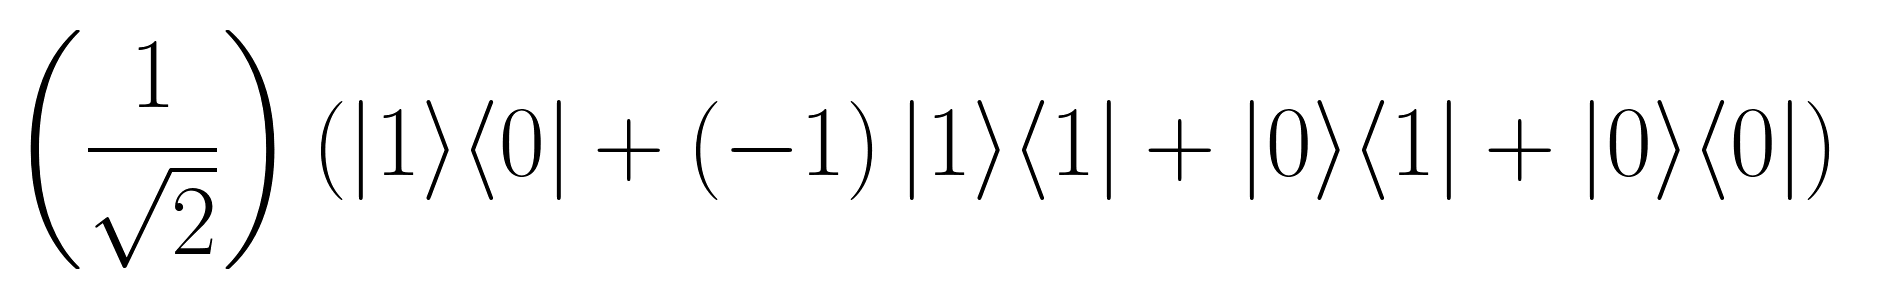

In [4]:
print(sub(parse(''' H ''')).tex())
sub(parse(''' H ''')).render_tex()

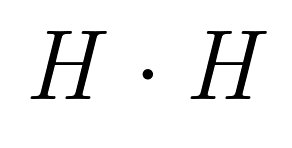

In [5]:
expr = parse(''' H MLTO H''')
expr.render_tex()

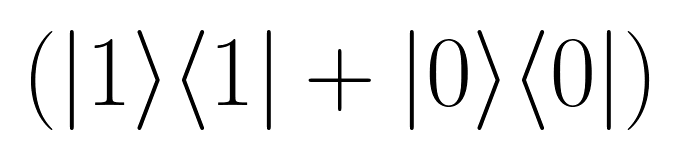

In [6]:
trs.normalize(sub(expr)).render_tex()

### Utilizing Wolfram Engine

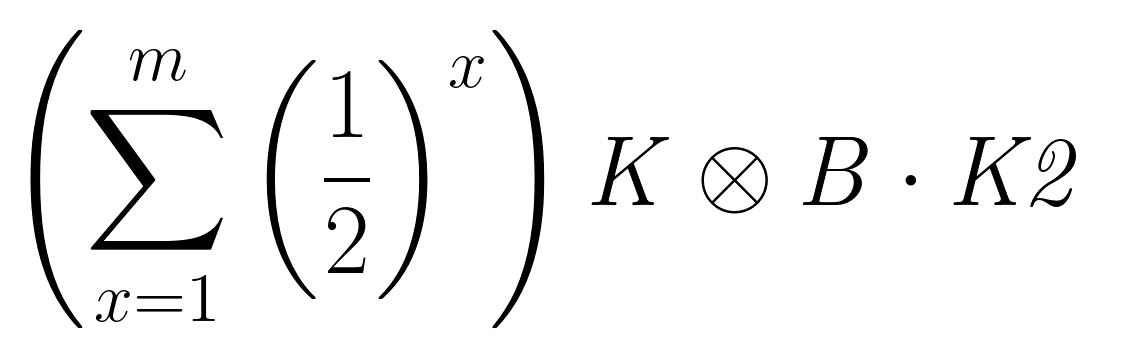

In [7]:
expr = parse(''' "HoldForm[Sum[(1/2)^x, {x, 1, m}]]" SCRO ((K OUTER B) MLTK K2) ''')
expr.render_tex()

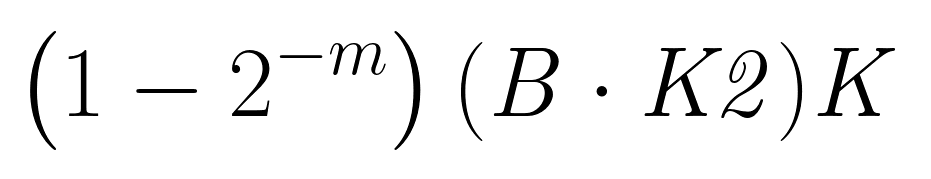

In [8]:
trs.normalize(expr).render_tex()

### Rotation decompostion

In [9]:

# define the rotation gates
sub_rot = Subst({
    "Rzbeta" : sub(parse(''' ("Cos[beta/2]" SCRO I2) ADDO ("- Sin[beta/2] I" SCRO Z) ''')),
    "Rygamma" : sub(parse(''' ("Cos[gamma/2]" SCRO I2) ADDO ("- Sin[gamma/2] I" SCRO Y) ''')),
    "Rzdelta" : sub(parse(''' ("Cos[delta/2]" SCRO I2) ADDO ("- Sin[delta/2] I" SCRO Z) ''')),
})

# get the idempotent operation
new_sub = sub_rot.composite(sub).get_idempotent()

# RHS - rotations
a = new_sub(parse(''' "Exp[I a]" SCRO (Rzbeta MLTO Rygamma MLTO Rzdelta) '''))
# LHS - U
b = new_sub(parse(''' ("Exp[I (a - beta/2 - delta/2)] Cos[gamma/2]" SCRO (ket0 OUTER bra0))
    ADDO ("- Exp[I (a - beta/2 + delta/2)] Sin[gamma/2]" SCRO (ket0 OUTER bra1)) 
    ADDO ("Exp[I (a + beta/2 - delta/2)] Sin[gamma/2]" SCRO (ket1 OUTER bra0))
    ADDO ("Exp[I (a + beta/2 + delta/2)] Cos[gamma/2]" SCRO (ket1 OUTER bra1))'''))

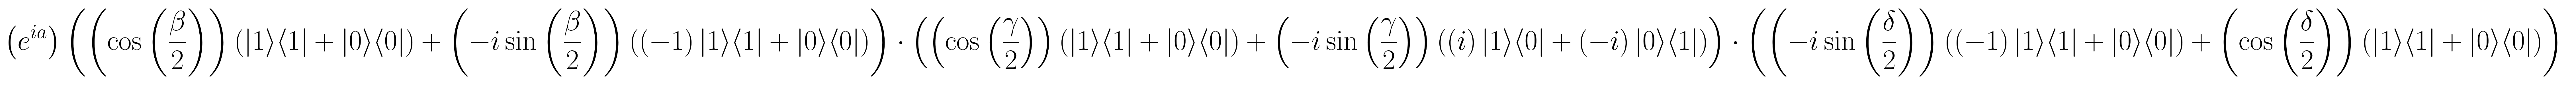

In [10]:
a.render_tex()

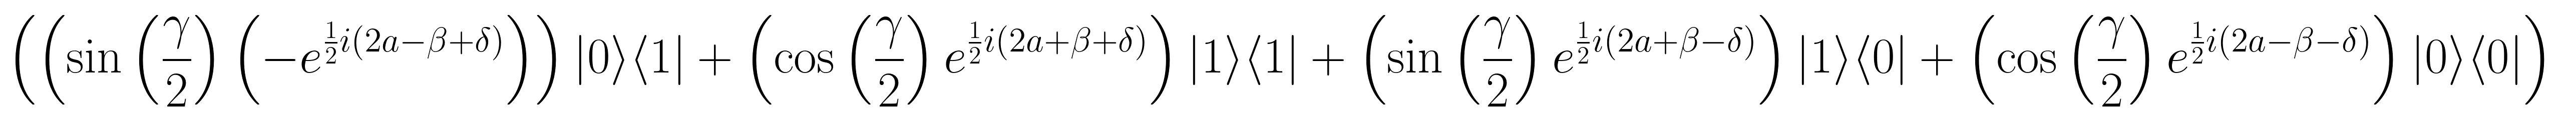

In [11]:
b.render_tex()

In [12]:
norm_a = trs.normalize(sub(a))
norm_b = trs.normalize(sub(b))
assert norm_a == norm_b

### Circuit Example

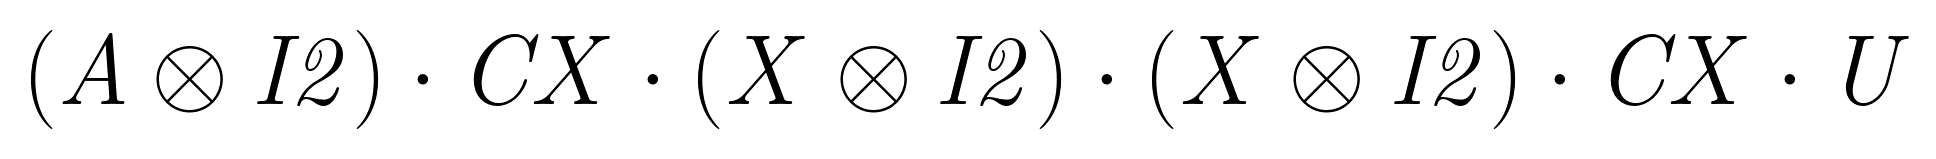

In [13]:
# the LHS circuit representation
circ1 = parse(''' (A TSRO I2) MLTO CX MLTO (X TSRO I2) MLTO (X TSRO I2) MLTO CX MLTO U ''')
circ1.render_tex()

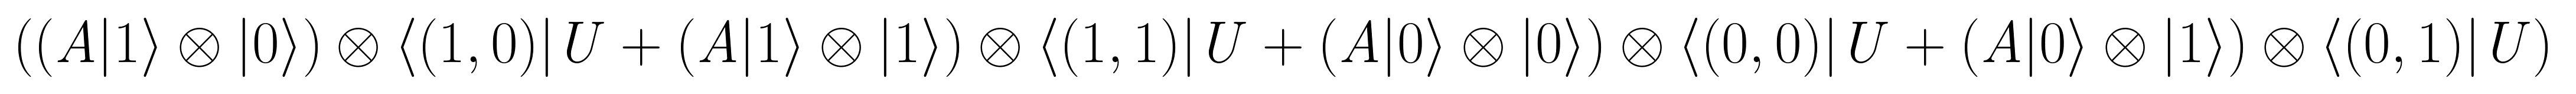

In [14]:
# the normalized result
norm_circ1 = trs.normalize(sub(circ1))
norm_circ1.render_tex()

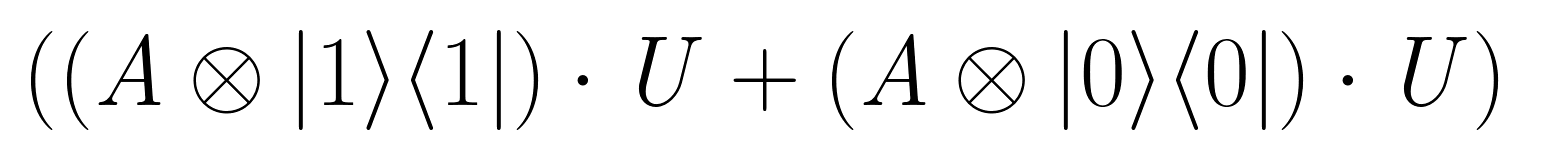

In [15]:
# the RHS circuit representation and normalized result
circ2 = parse(''' (A TSRO I2) MLTO U ''')
trs.normalize(sub(circ2)).render_tex()

True


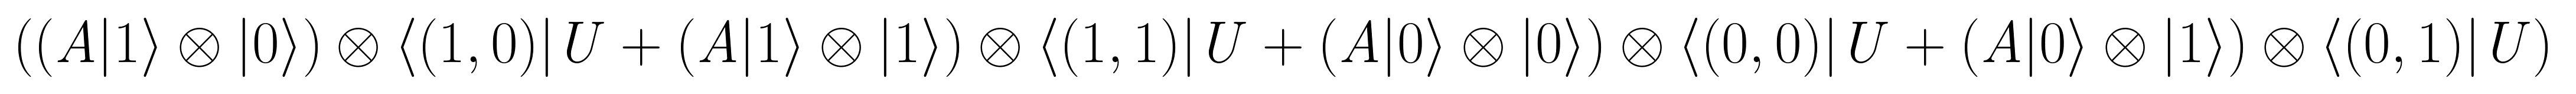

In [16]:
circ2_ = parse(''' (A TSRO I2) MLTO (I2 TSRO 1O) MLTO U ''')

norm_circ2 = trs.normalize(sub(circ2_))
print(norm_circ1 == norm_circ2)
norm_circ2.render_tex()

## Playground

In [17]:
a = parse(''' "Hold[Sum[(1/2)^i, {i,1,Infinity}] a + a] " ''')

a.tex()
# trs.normalize(a).render_tex()


'\\left (\\text{Hold}\\left[a \\left(\\sum _{i=1}^{\\infty } \\left(\\frac{1}{2}\\right)^i\\right)+a\\right]\\right )'

In [18]:
b = session.evaluate(" Hold[Sum[(1/2)^i, {i,1,Infinity}] a + a] ")